# Tutorial-LSTM: Project for testing LSTM time series forecasting

**Notebook number 2/2**

This is a short deep learning tutorial to show how to implement LSTM time series forecasting using the cookiecutter Deep Learning template: https://github.com/tdeboissiere/cookiecutter-deeplearning

This template is very flexible and clear, but sometimes is not evidence for inexperienced programmer nor deep learning beginners how to use it.

The original example code comes from: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/ . In notebook 1/2, we renamed files and variables just following the template example notation. Also, this notation is very often used in Keras documentation. So we prefer to notate the X train matrix as "X_train" and not "Train_X". In this notebook fully implement the deep learning template folder and files structure.



# Tutorial-LSTM

To make the code reproducible.

In [1]:
%load_ext watermark
%watermark -a 'Ramón Martín' -u -d -p numpy,scipy,matplotlib,sklearn

Ramón Martín 
last updated: 2018-01-17 

numpy 1.13.1
scipy 0.19.1
matplotlib 2.0.2
sklearn 0.19.0


# 1. Air Pollution Forecasting

### 1. Import libraries and modules. Load env variables

In [2]:
## 1. Import libraries and modules. Load env variables
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
import numpy as np
np.random.seed(123)  # for reproducibility
from numpy import concatenate
from math import sqrt
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from dotenv import find_dotenv, load_dotenv

#Reads the key,value pair from .env and adds them to environment variable 
load_dotenv(find_dotenv())

# Check the env variables exist. Check as many variables as you need
raw_msg = "Set your raw data absolute path in the .env file at project root"
assert "RAW_DIR" in os.environ, raw_msg
data_msg = "Set your processed data absolute path in the .env file at project root"
assert "DATA_DIR" in os.environ, data_msg
interim_msg = "Set your interim data absolute path in the .env file at project root"
assert "INTERIM_DIR" in os.environ, interim_msg

# Load env variables
proj_dir = os.path.expanduser(os.environ.get("PROJ_DIR"))
data_dir = os.path.expanduser(os.environ.get("DATA_DIR"))
raw_dir = os.path.expanduser(os.environ.get("RAW_DIR"))
interim_dir = os.path.expanduser(os.environ.get("INTERIM_DIR"))
processed_dir = os.path.expanduser(os.environ.get("PROCESSED_DIR"))
figures_dir = os.path.expanduser(os.environ.get("FIGURES_DIR"))
model_dir = os.path.expanduser(os.environ.get("MODEL_DIR"))
external_dir = os.path.expanduser(os.environ.get("EXTERNAL_DIR"))

#Import Project our modules
#
#Add src/app to the PATH
sys.path.append(os.path.join(proj_dir,"src/app"))
#Add src/data to the PATH
sys.path.append(os.path.join(proj_dir,"src/data"))
import make_dataset as md
#Add src/visualization to the PATH
sys.path.append(os.path.join(proj_dir,"src/visualization"))
import visualize as vs

#Data files
raw_data = os.path.join(raw_dir,"PRSA_data_2010.1.1-2014.12.31.csv")
interim_data = os.path.join(interim_dir,"pollution.csv")

Using TensorFlow backend.


In [3]:
print(os.environ['FIGURES_DIR'])

/home/parrondo/projects/research/tutorial-LSTM/reports/figures/


In [4]:
print(module_path)

/home/parrondo/projects/research/tutorial-LSTM


### 2. Download raw data sets

In [5]:
## 2. Download raw data sets

#This point must be adapted for each project
import requests

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv"
filename = "PRSA_data_2010.1.1-2014.12.31.csv"
# >> False
r = requests.get(url, allow_redirects=True)
open(raw_data, 'wb').write(r.content) #write de data file into the actual notebook or .py folder

2010494

Download .csv data file from https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data and save in ../data/raw dir

# 2. Basic Data Preparation

In [6]:
#Clean data and parse dates
md.clean_data(filename)

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


'Raw data cleaned yet'

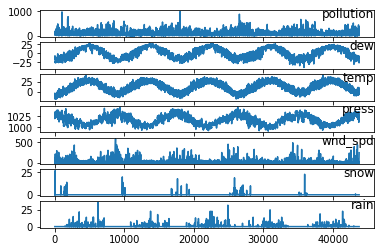

In [7]:
#visualize interim data
vs.visualize(interim_data)

# 3. Multivariate LSTM Forecast Model

## LSTM Data Preparation

In [8]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    args:
        data (list or NumPy array) Sequence of observations.
        n_in (int) Number of lag observations as input (X).
        n_ou: (int)  Boolean whether or not to drop rows with NaN values.
    yields:
        agg (Pandas DataFrame) of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [9]:
# load dataset
dataset = read_csv(interim_data, header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
4   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
5   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-1)  var8(t-1)   var1(t)  
1   0.000000        0.0  0.148893  
2   0.000000        0.0  0.159960  
3   0.000000        0.0  0.182093  
4   0.037037        0.0  0.138833  
5   0.074074        0.0  0.109658  


## Define and Fit Model

In [10]:
# split into train and test sets
values = reframed.values
n_years = 1
n_train_hours = 365 * 24 * n_years
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
X_train, y_train = train[:, :-1], train[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)


Train on 8760 samples, validate on 35039 samples
Epoch 1/50
1s - loss: 0.0537 - val_loss: 0.0552
Epoch 2/50
0s - loss: 0.0356 - val_loss: 0.0454
Epoch 3/50
0s - loss: 0.0203 - val_loss: 0.0371
Epoch 4/50
0s - loss: 0.0158 - val_loss: 0.0199
Epoch 5/50
0s - loss: 0.0150 - val_loss: 0.0156
Epoch 6/50
0s - loss: 0.0148 - val_loss: 0.0142
Epoch 7/50
0s - loss: 0.0147 - val_loss: 0.0141
Epoch 8/50
0s - loss: 0.0146 - val_loss: 0.0141
Epoch 9/50
0s - loss: 0.0147 - val_loss: 0.0138
Epoch 10/50
0s - loss: 0.0145 - val_loss: 0.0138
Epoch 11/50
0s - loss: 0.0146 - val_loss: 0.0138
Epoch 12/50
0s - loss: 0.0145 - val_loss: 0.0135
Epoch 13/50
0s - loss: 0.0145 - val_loss: 0.0134
Epoch 14/50
0s - loss: 0.0145 - val_loss: 0.0133
Epoch 15/50
0s - loss: 0.0146 - val_loss: 0.0134
Epoch 16/50
0s - loss: 0.0146 - val_loss: 0.0134
Epoch 17/50
0s - loss: 0.0145 - val_loss: 0.0134
Epoch 18/50
0s - loss: 0.0145 - val_loss: 0.0136
Epoch 19/50
0s - loss: 0.0144 - val_loss: 0.0135
Epoch 20/50
0s - loss: 0.0145

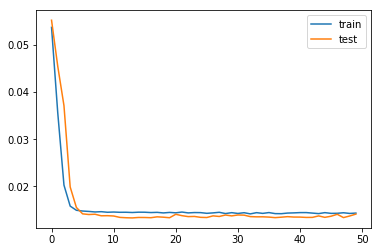

In [11]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(X_train, y_train, epochs=50, batch_size=72, validation_data=(X_test, y_test), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# Evaluate Model

In [12]:
# make a prediction
yhat = model.predict(X_test)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))
# invert scaling for forecast
yhat_inv = concatenate((yhat, X_test[:, 1:]), axis=1)
yhat_inv = scaler.inverse_transform(yhat_inv)
yhat_inv = yhat_inv[:,0]
# invert scaling for actual
y_test = y_test.reshape((len(y_test), 1))
y_inv = concatenate((y_test, X_test[:, 1:]), axis=1)
y_inv = scaler.inverse_transform(y_inv)
y_inv = y_inv[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(y_inv, yhat_inv))
print('Test RMSE: %.3f' % rmse)
y_test

Test RMSE: 26.780


array([[ 0.03118712],
       [ 0.02012072],
       [ 0.01911469],
       ..., 
       [ 0.01006036],
       [ 0.00804829],
       [ 0.01207243]], dtype=float32)